<a href="https://colab.research.google.com/github/eduardocoraca/doc/blob/main/avaliacao_z24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive/')
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import scipy.io
import re
from sklearn.cluster import KMeans

Mounted at /content/drive/


In [ ]:
!cp '/content/drive/MyDrive/Doutorado/TAESA/Modelos/lib_eduardo.py' .
import lib_eduardo

In [ ]:
!pip install hmmlearn
from hmmlearn.hmm import *

     |████████████████████████████████| 378kB 8.1MB/s 


In [ ]:
# carregando o modelo treinado

import pickle
#filename = '/content/drive/MyDrive/Doutorado/Dataset/Z24/Modelos/m1.mod'
filename = '/content/drive/MyDrive/Doutorado/Dataset/Z24/Modelos/m2_freq_ref.mod'

obj = pickle.load(open(filename, 'rb'))

ae = obj[0]
hmm_h = obj[1]
cl_h = obj[2]



*   64 segundos
*   intervalos de 1h



In [ ]:
def loader_pdt(scenario, excit):
  setups = ['01','02','03','04','05','06','07','08','09']
  
  # para o primeiro setup
  setup = setups[0]
  path = '/content/drive/MyDrive/Doutorado/Dataset/Z24/pdt/' + scenario + '/' + excit + '/' + scenario + 'setup' + setup + '.mat'
  d = scipy.io.loadmat(path)
  df = pd.DataFrame(data=d['data'], columns=d['labelshulp'])

  # para os demais setups
  for setup in setups[1:]:
    path = '/content/drive/MyDrive/Doutorado/Dataset/Z24/pdt/' + scenario + '/' + excit + '/' + scenario + 'setup' + setup + '.mat'
    d = scipy.io.loadmat(path)
    df_s = pd.DataFrame(data=d['data'], columns=d['labelshulp'])
    df = pd.concat([df, df_s], axis=1)

  return df

def get_index(d):
  # função para retornar as posições em que se mediram 3 canais (L,T,V)
  s = list(d.columns)
  s = list(map(lambda x: x.strip(), s))
  st = list(map(lambda x: len(x.split('T'))-1, s))
  sl = list(map(lambda x: len(x.split('L'))-1, s))
  sv = list(map(lambda x: len(x.split('V'))-1, s))

  s = list(map(lambda x: x[0:-1], s))
  df = pd.DataFrame(s)
  df['T'] = st
  df['L'] = sl
  df['V'] = sv

  df2 = df.groupby([0], as_index=False).sum()
  df2['soma'] = df2.sum(axis=1)

  return np.array(df2.loc[df2['soma']==3,0], dtype='int')

def get_tensor(indices, dicionario, dataframe):
  # função para retornar o tensor contendo os 3 canais de cada local (indices) 
  x = np.zeros((len(indices), 3, len(dataframe)))
  for id in indices:
    col_L = id+'L'
    col_T = id+'T'
    col_V = id+'V'
    x[dicionario[id],0,:] = dataframe[col_L]
    x[dicionario[id],1,:] = dataframe[col_T]
    x[dicionario[id],2,:] = dataframe[col_V]
  return x

In [ ]:
cenarios = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17']

d = []
for c in tqdm(cenarios):
  d.append(loader_pdt(scenario=c, excit='fvt'))

100%|██████████| 17/17 [02:02<00:00,  7.19s/it]


In [ ]:
indices = ['431','432', '204','208','213','214','218','219','224','229','234','239', '531','532']

NUM_SENSORS = len(indices)

In [ ]:
# Dicionário para os locais selecionados
dic = {}
cont = 0
for ind in indices:
  dic[ind] = cont
  cont+=1
dic

{'204': 2,
 '208': 3,
 '213': 4,
 '214': 5,
 '218': 6,
 '219': 7,
 '224': 8,
 '229': 9,
 '234': 10,
 '239': 11,
 '431': 0,
 '432': 1,
 '531': 12,
 '532': 13}

In [ ]:
x = []
for k in range(len(cenarios)):
  x.append(get_tensor(indices, dic, d[k]))

In [ ]:
NUM_FILES = len(x)

In [ ]:
NUM_CHANNELS = 3

In [ ]:
x[10].shape

(14, 3, 65536)

# **Cálculo das PSD**

In [ ]:
# L = 1024 # quantidade de pontos na janela temporal
L = 2048

xr = []
for k in range(NUM_FILES):
  xr.append(lib_eduardo.reshape_signal(x[k][:,:,:], L))

NameError: ignored

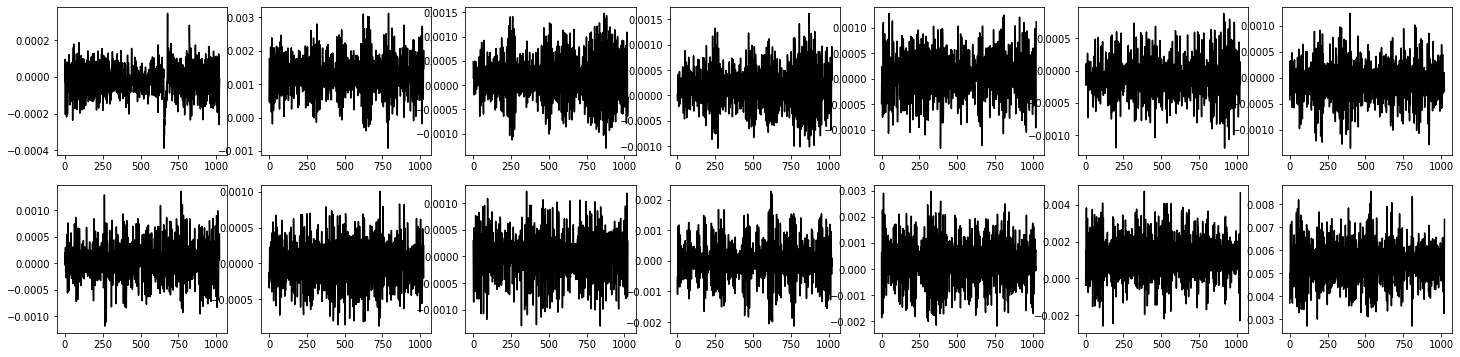

In [ ]:
plt.figure(figsize=(25,6))
for k in range(NUM_SENSORS):
  plt.subplot(2,NUM_SENSORS/2,k+1)
  plt.plot(xr[0][k,0,0,:], color='black')

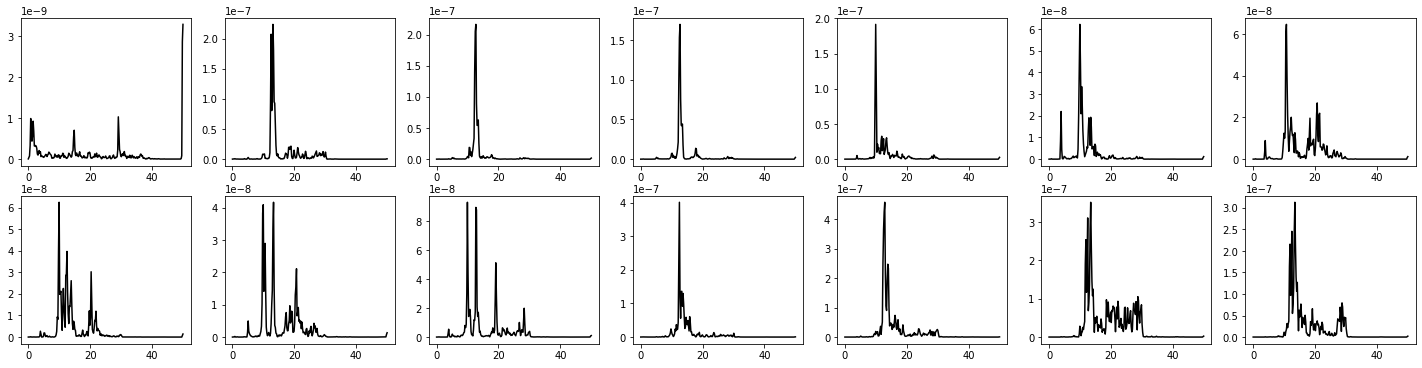

In [ ]:
nw = 1024

X = []
for k in range(NUM_FILES):
  f, S = lib_eduardo.get_psd(xr[k], nw=nw, no=int(0.8*nw), dt=1/100)
  X.append(S)

plt.figure(figsize=(25,6))
for k in range(NUM_SENSORS):
  plt.subplot(2,NUM_SENSORS/2,k+1)
  plt.plot(f, X[0][k,0,0,:], color='black')

In [ ]:
# Selecionando frequências até 30Hz
idx = np.where(f<30)[0][-1] + 1

for k in range(NUM_FILES):
  X[k] = X[k][:,:,:,0:idx]
f = f[0:idx]

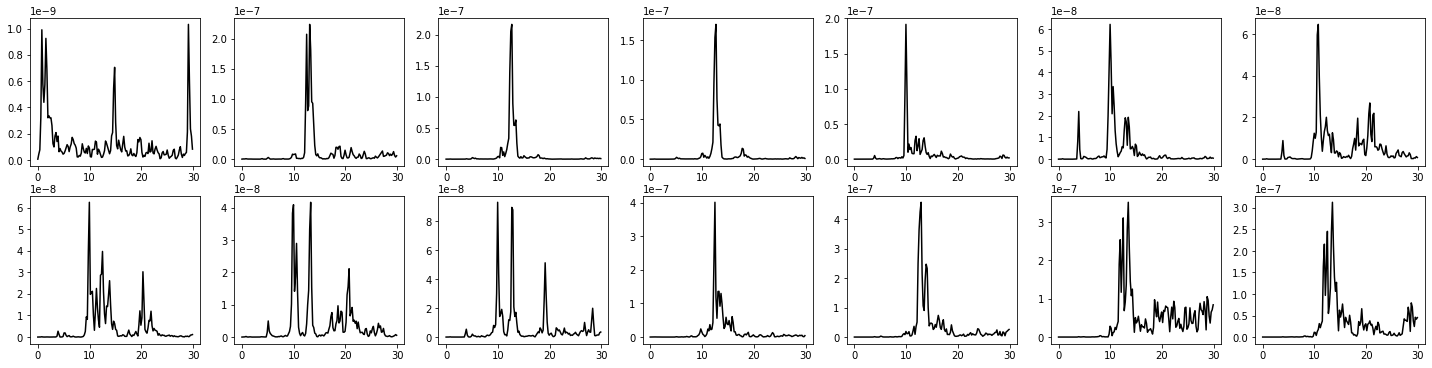

In [ ]:
plt.figure(figsize=(25,6))
for k in range(NUM_SENSORS):
  plt.subplot(2,NUM_SENSORS/2,k+1)
  plt.plot(f, X[0][k,0,0,:], color='black')

# **Geradores**

In [ ]:
X = list(map(lib_eduardo.swap, X))

In [ ]:
X[0].shape

(63, 3, 14, 154)

In [ ]:
BATCH_SIZE = 10

ger = []
for k in range(NUM_FILES):
  ger.append(lib_eduardo.Gerador(X[k], batch_size=BATCH_SIZE, shuffle=False, log=True, norm=True))

# **Saídas do encoder**

In [ ]:
enc = []
for k in range(0, NUM_FILES):
  enc.append(ae.encode(torch.Tensor(ger[k].get_data())).to('cpu').detach().numpy())

In [ ]:
lengths = list(map(len, enc))
ticks = np.cumsum(lengths)

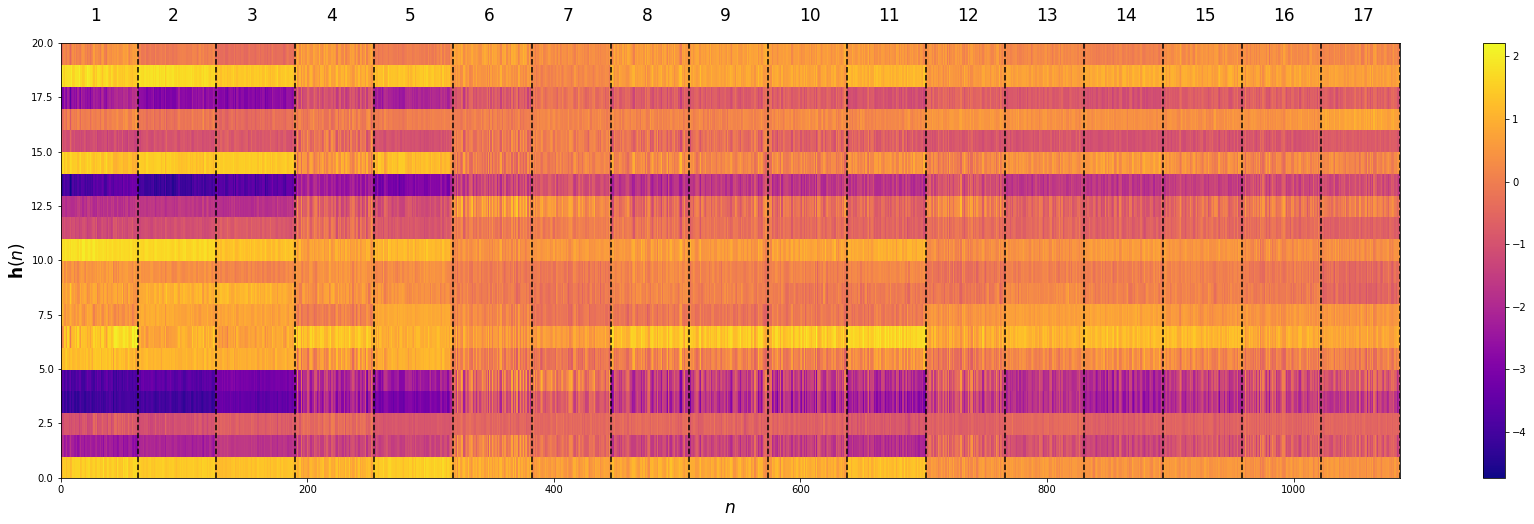

In [ ]:
# Visualizando
titles = []
for k in range(NUM_FILES):
  titles.append(str(k+1))

plt.figure(figsize=(30,8))
plt.pcolormesh(np.concatenate((enc), axis=0).T, cmap='plasma'); plt.xlabel('$n$', fontsize=17);

for k in range(len(ticks)):
  plt.plot([ticks[k], ticks[k]], [0, ae.encode_dim], linestyle='dashed', c='k')
  if k ==0 :
    plt.text(ticks[k]//2 - 7, ae.encode_dim+1, '$1$', fontsize=17)
  else:
    plt.text((ticks[k-1] + ticks[k])//2 - 7, ae.encode_dim+1, titles[k], fontsize=17)

plt.ylabel('$\mathbf{h}(n)$', fontsize=17)
plt.colorbar();

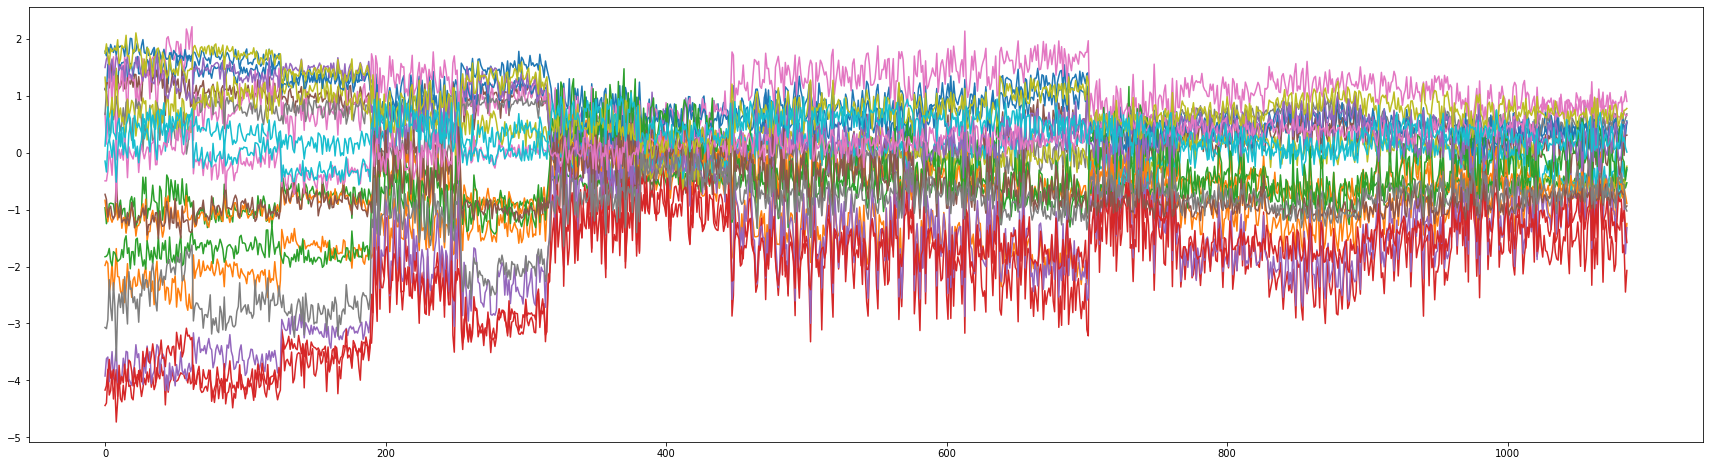

In [ ]:
plt.figure(figsize=(30,8))
for k in range(ae.encode_dim):
  plt.plot((np.concatenate((enc), axis=0).T)[k,:])

# **HMM**

In [ ]:
L = 15 # intervalo considerado pela HMM

In [ ]:
# Verossimilhanças
xall_seq, _ = lib_eduardo.reshape(np.concatenate(enc), L, L-1)
pred_all = []
for seq in tqdm(xall_seq):
  pred_all.append(hmm_h.score(seq))

100%|██████████| 1072/1072 [00:00<00:00, 1370.26it/s]


In [ ]:
# separando as classes
# no caso da HMM, precisamos retirar L do primeiro intervalo

lengths_hmm = lengths.copy()
lengths_hmm[0] = lengths_hmm[0] - L
ticks_hmm = np.cumsum(lengths_hmm)

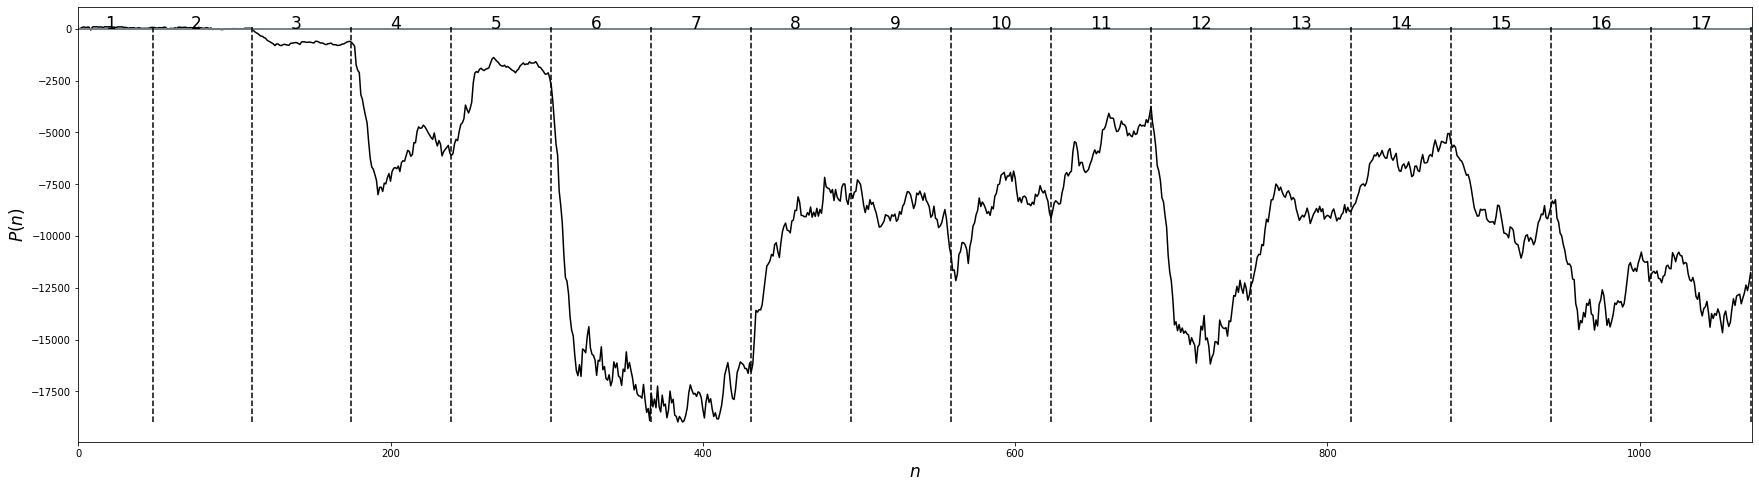

In [ ]:
plt.figure(figsize=(30,8))

thresh = 0

#lib_eduardo.plot_thresh(pred_all, thresh)
plt.plot(pred_all, 'k')
plt.plot([0,len(pred_all)],[thresh,thresh])

plt.xlabel('$n$', fontsize=17);
plt.ylabel('$P(n)$', fontsize=17);
plt.plot([0,len(pred_all)],[thresh, thresh], c='gray');
plt.xlim([0, len(pred_all)]);
#plt.ylim([np.min(pred_all), np.max(pred_all)]);

for k in range(len(ticks)):
  plt.plot([ticks_hmm[k], ticks_hmm[k]], [np.min(pred_all), np.max(pred_all)], linestyle='dashed', c='k')
  if k ==0 :
    plt.text(ticks_hmm[k]//2 - 7, ae.encode_dim+1, '$1$', fontsize=17)
  else:
    plt.text((ticks_hmm[k-1] + ticks_hmm[k])//2 - 7, ae.encode_dim+1, titles[k], fontsize=17)

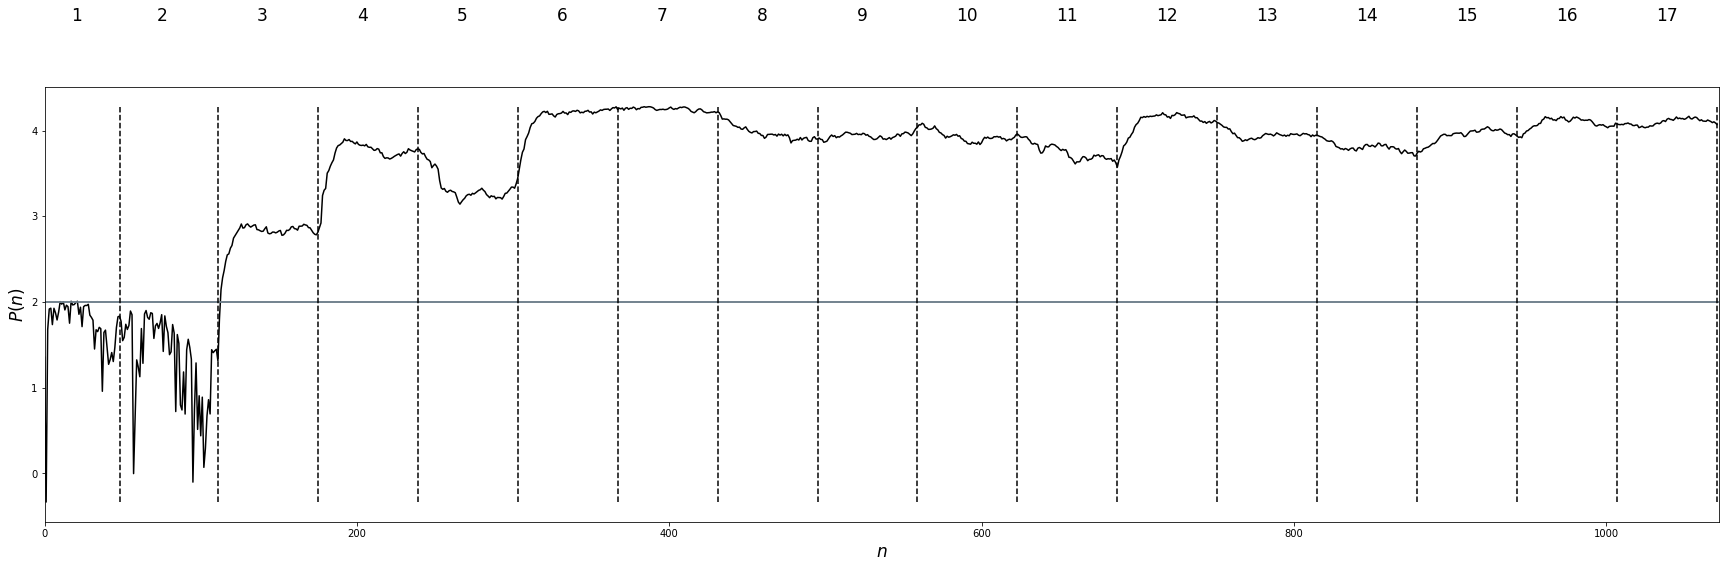

In [ ]:
plt.figure(figsize=(30,8))

thresh = 2

#lib_eduardo.plot_thresh(pred_all, thresh)
plt.plot(pred_abs, 'k')
plt.plot([0,len(pred_abs)],[thresh,thresh])

plt.xlabel('$n$', fontsize=17);
plt.ylabel('$P(n)$', fontsize=17);
plt.plot([0,len(pred_abs)],[thresh, thresh], c='gray');
plt.xlim([0, len(pred_abs)]);
#plt.ylim([np.min(pred_all), np.max(pred_all)]);

for k in range(len(ticks)):
  plt.plot([ticks_hmm[k], ticks_hmm[k]], [np.min(pred_abs), np.max(pred_abs)], linestyle='dashed', c='k')
  if k ==0 :
    plt.text(ticks_hmm[k]//2 - 7, np.max(pred_abs)+1, '$1$', fontsize=17)
  else:
    plt.text((ticks_hmm[k-1] + ticks_hmm[k])//2 - 7, np.max(pred_abs)+1, titles[k], fontsize=17)

In [ ]:
pred_abs = list(map(np.abs, pred_all))
pred_abs = np.log10(np.array(pred_abs)+0.01)

# Estados

In [ ]:
# Estados
pred_state = hmm_h.predict(np.concatenate(enc))

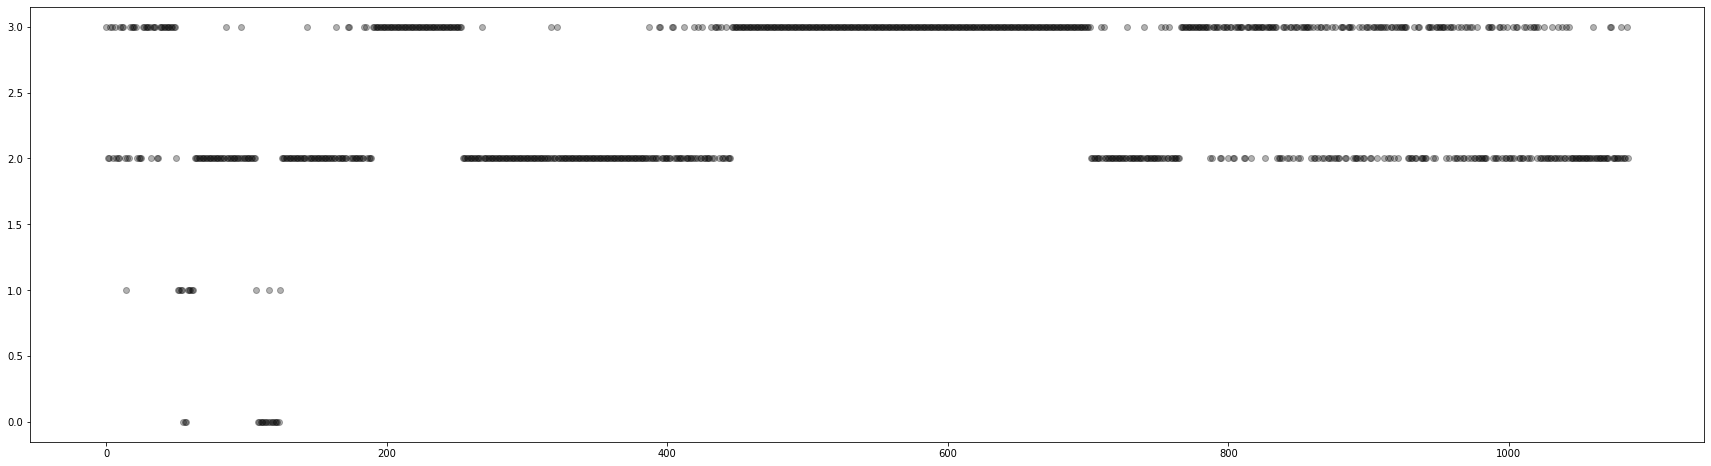

In [ ]:
plt.figure(figsize=(30,8))
plt.scatter(np.arange(0,len(pred_state)), pred_state, color='k', alpha=0.3)

# **Erros de reconstrução**

In [ ]:
dec = []
for k in range(0, NUM_FILES):
  dec.append(ae.decode(torch.Tensor(enc[k])).to('cpu').detach().numpy())

# re-organizando os geradores
gers = []
for k in range(0, len(ger)):
  gers.append(ger[k])

In [ ]:
# calculando os erros
e = []
for k in range(len(dec)):
  e.append(lib_eduardo.get_erro(dec[k], gers[k]))

In [ ]:
# calculando clusters para os intervalos

e_cat = np.concatenate(e, axis=0)
e_cat_list,_ = lib_eduardo.reshape_erro(e_cat, L=L, overlap=L-1)

centros = []
for k in range(len(e_cat_list)):
  temp = []
  for s in range(NUM_SENSORS):
    cl = KMeans(n_clusters = 1).fit(e_cat_list[k][:,:,s])
    temp.append(cl.cluster_centers_)
  centros.append(np.array(temp))
centros = np.array(centros).squeeze()

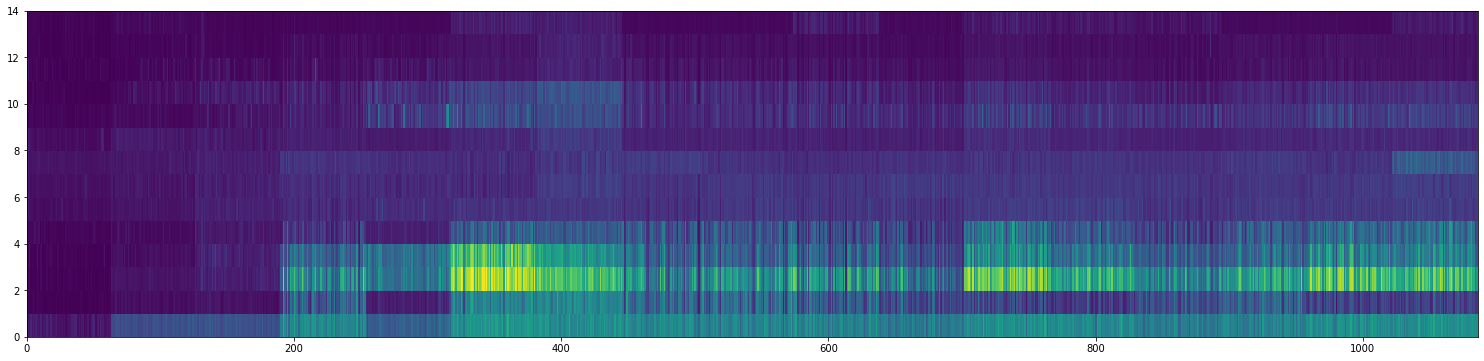

In [ ]:
plt.figure(figsize=(26,6))
plt.pcolormesh(e_cat[:,0,:].T)

In [ ]:
# calculando distâncias euclidianas ao cluster saudável
d = np.zeros(shape=(centros.shape[0], centros.shape[1]))

for k in range(centros.shape[0]):
  for s in range(NUM_SENSORS):
    soma = 0
    for c in range(NUM_CHANNELS):
      soma += (centros[k,s,c] - cl_h[s].cluster_centers_[0][0])**2
    d[k,s] = np.sqrt(soma)

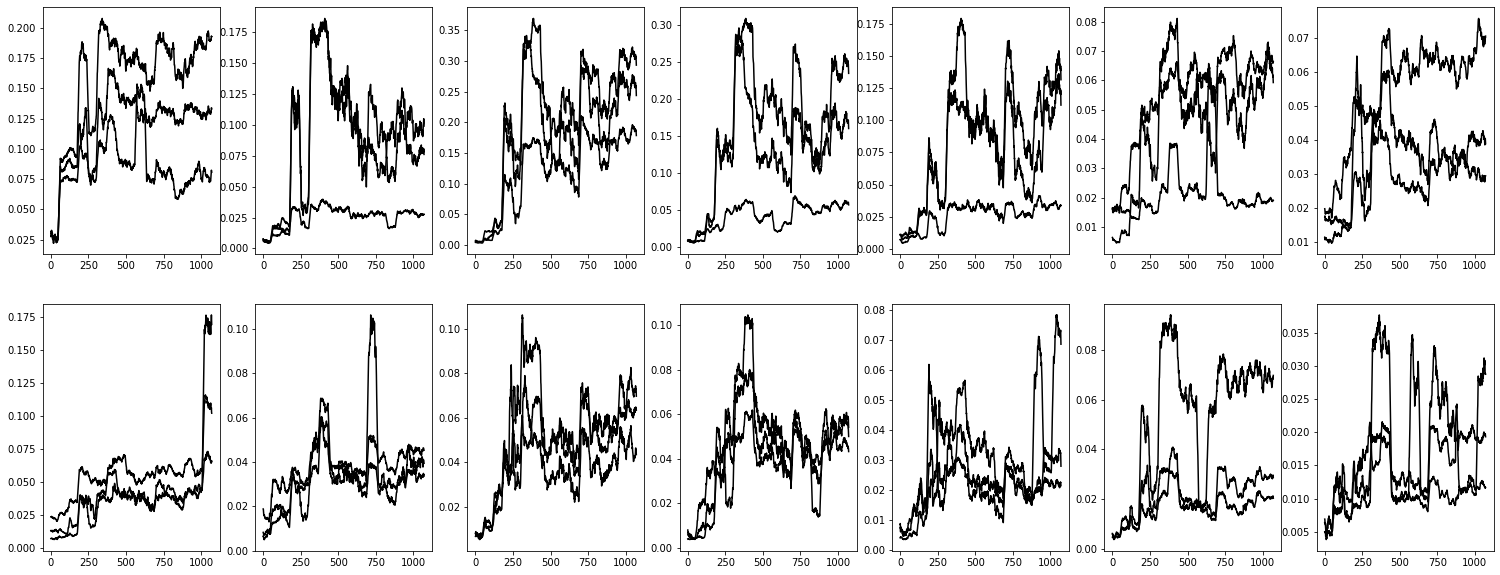

In [ ]:
plt.figure(figsize=(26,10))
for k in range(NUM_SENSORS):
  plt.subplot(2,NUM_SENSORS/2,k+1)
  plt.plot(np.array(centros)[:,k], 'k')

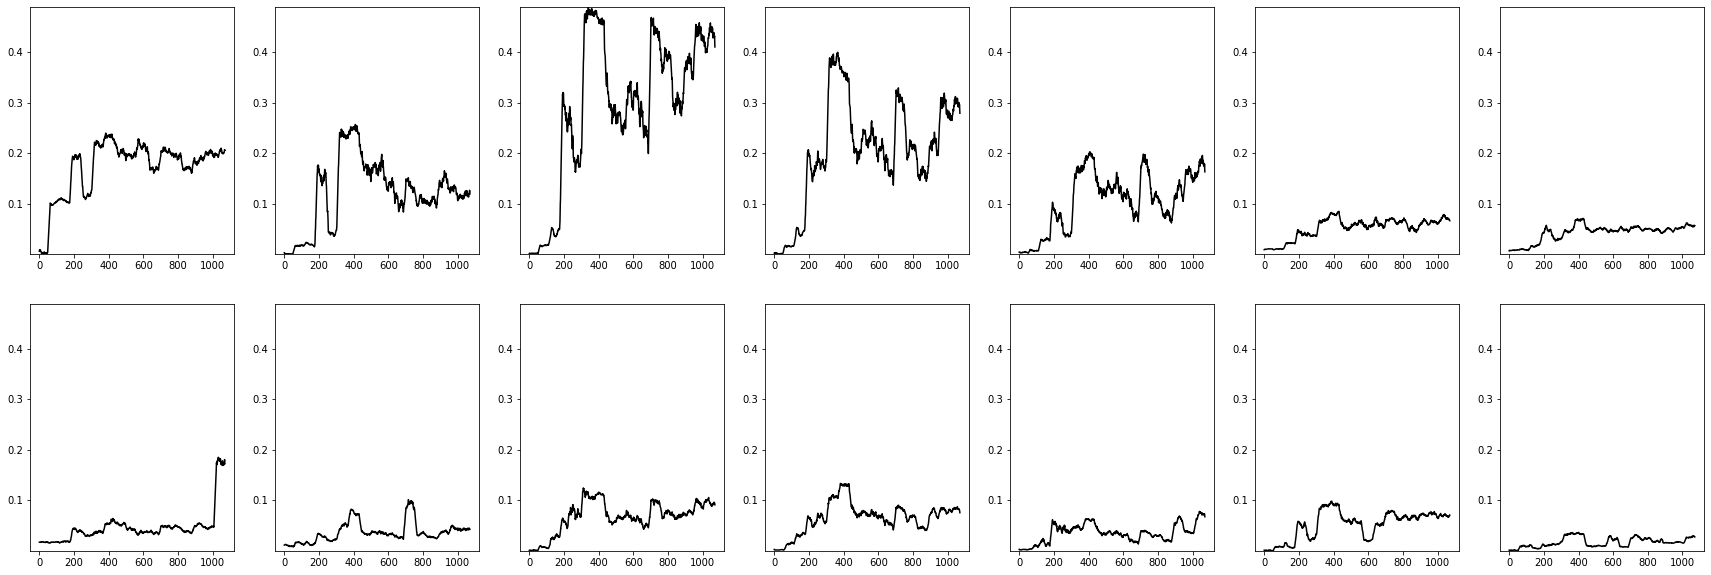

In [ ]:
plt.figure(figsize=(30,10))
for k in range(NUM_SENSORS):
  plt.subplot(2,NUM_SENSORS/2,k+1)
  plt.plot(d[:,k], 'k')
  plt.ylim([d.min(), d.max()])

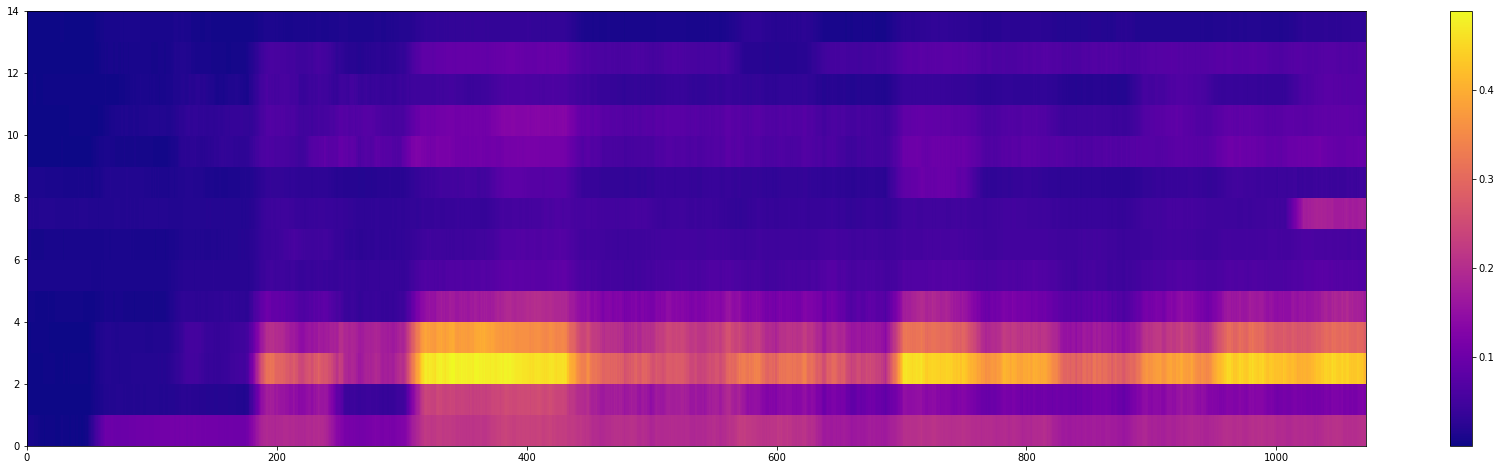

In [ ]:
plt.figure(figsize=(30,8))
plt.pcolormesh(d.T, cmap='plasma')
plt.colorbar()

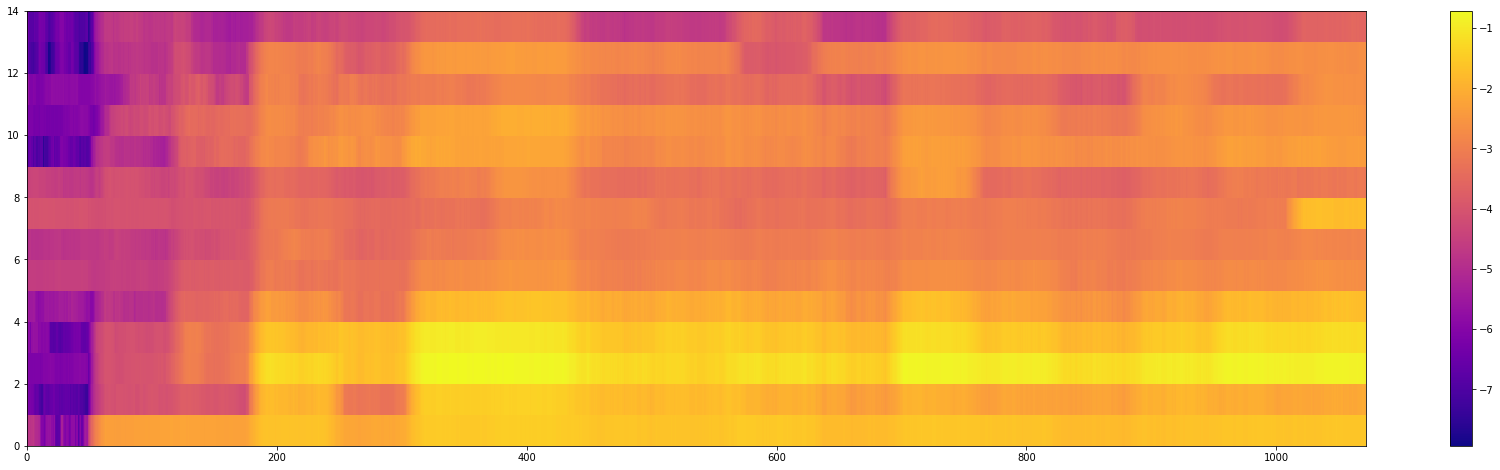

In [ ]:
plt.figure(figsize=(30,8))
plt.pcolormesh(np.log(d).T, cmap='plasma')
plt.colorbar()